## Day 34 Lecture 2 Assignment

In this assignment, we will learn about gradient boosting. We will use a dataset of house information in Ames, Iowa, predicting sale price.

In [127]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [85]:
house = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/houseprices.csv')
print(house.shape)
house.head()

(1460, 81)


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,...,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [88]:
house.shape

(1460, 81)

Check for nulls. Remove any columns with more than 100 nulls, then drop any remaining rows with nulls after that.

In [89]:
nullcheck = house.isnull().sum()

In [90]:
ctr = 0

for i in nullcheck.values:
    if i > 100:
        print(f'Dropping {nullcheck.index[ctr]}')
        house.drop([nullcheck.index[ctr]], axis=1, inplace=True)
    ctr += 1

house.dropna(inplace=True)

Dropping lotfrontage
Dropping alley
Dropping fireplacequ
Dropping poolqc
Dropping fence
Dropping miscfeature


In [91]:
house.head()

,id,mssubclass,mszoning,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


In [92]:
house.drop('id', axis=1, inplace=True)

One hot encode your categorical features using get_dummies.

In [119]:
cat = ['mssubclass','mszoning','street','lotshape','landcontour',
       'utilities', 'lotconfig', 'landslope', 'neighborhood', 'condition1',
       'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl',
       'exterior1st', 'exterior2nd', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'garagetype', 'garagefinish', 'garagequal', 'garagecond',
       'paveddrive', 'saletype', 'salecondition', 'masvnrtype']

n = pd.get_dummies(house[cat], drop_first=True)
nhouse = pd.concat([n, house], axis=1)
nhouse.drop(cat, axis=1, inplace=True)

In [111]:
nhouse

,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave,lotshape_IR2,lotshape_IR3,lotshape_Reg,landcontour_HLS,landcontour_Low,landcontour_Lvl,utilities_NoSeWa,lotconfig_CulDSac,lotconfig_FR2,lotconfig_FR3,lotconfig_Inside,landslope_Mod,landslope_Sev,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_IDOTRR,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,...,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrtype,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,8450,7,5,2003,2003,BrkFace,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,9600,6,8,1976,1976,None,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,11250,7,5,2001,2002,BrkFace,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,9550,7,5,1915,1970,None,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,14260,8,5,2000,2000,BrkFace,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,7917,6,5,1999,2000,None,0.0,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,1999.0,2,460,0,40,0,0,0,0,0,8,2007,175000
1456,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,13175,6,6,1978,1988,Stone,119.0,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,1978.0,2,500,349,0,0,0,0,0,0,2,2010,210000
1457,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,9042,7,9,1941,2006,None,0.0,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1941.0,1,252,0,60,0,0,0,0,2500,5,2010,266500
1458,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,9717,5,6,1950,1996,None,0.0,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1950.0,1,240,366,0,112,0,0,0,0,4,2010,142125


Take a look at your outcome variable. It is highly skewed, and has a few very rare large outliers.

Let's try log transforming the y variable.

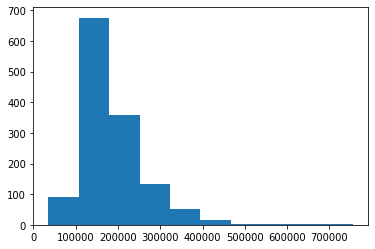

In [115]:
plt.hist(nhouse.saleprice)
plt.show()

We know that there are some rare large values. We can make sure that the training and test sets have about the same distribution by stratifying the train-test split.

Split your training and test sets, with a test size of 0.2. Use the given helper function to stratify the continuous outcome. Remember that the outcome variable is now the **log of sale price**.

In [120]:
def binned(y, num_bins):
    # Creates an object to put in the stratify keyword in train_test_split
    # Specify number of bins to separate your y variable
    ymin, ymax = y.min(), y.max()
    bins = np.linspace(ymin, ymax, num_bins+1)[:-1]
    y_binned = np.digitize(y, bins)
    return y_binned

In [121]:
X = nhouse.drop('saleprice', axis=1)
Y = np.log(nhouse.saleprice)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=binned(Y,2))

Create a Gradient Boosting Regressor model. Measure the MAE (Mean Absolute Error) for the training and testing sets.

In [122]:
gbr = GradientBoostingRegressor(learning_rate=0.4, max_depth=5, n_iter_no_change=10, n_estimators=10000)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.4, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=10000,
                          n_iter_no_change=10, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [125]:
y_train_pred = gbr.predict(X_train)
y_test_pred = gbr.predict(X_test)
print(f'Train MAE: ${mean_absolute_error(y_train,y_train_pred):,.4f} \nTest MAE: ${mean_absolute_error(y_test,y_test_pred):,.4f}')

Train MAE: $0.0377 
Test MAE: $0.1080


Create a grid search. Try varying subsample, learning rate, and max features. Use MAE as your scoring metric.

In [129]:
param = {'learning_rate':[0.1,0.3,0.5,0.7,0.9],'max_features':[0.25,0.5,0.75],'subsample':[0.1,0.3,0.6,0.9]}
gbr = GradientBoostingRegressor()
clf = GridSearchCV(gbr,param,scoring='neg_mean_absolute_error')
clf.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_ite...
                            

In [134]:
print('Best parameters: ',clf.best_params_)
print('Best score: ', np.absolute(clf.best_score_))

Best parameters:  {'learning_rate': 0.1, 'max_features': 0.25, 'subsample': 0.9}
Best score:  0.08539224722599772


Create residual plots of the training and test sets and interpret your results.

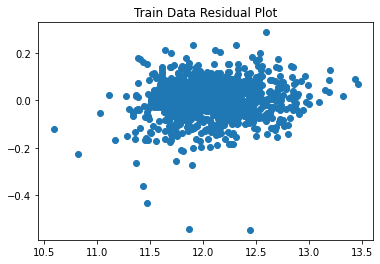

In [131]:
residual = y_train - clf.predict(X_train)
plt.scatter(clf.predict(X_train),residual)
plt.title('Train Data Residual Plot')
plt.show()

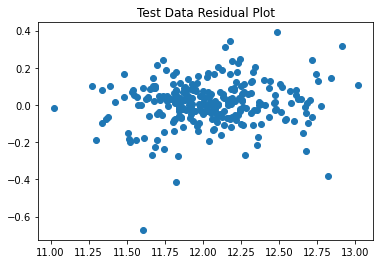

In [133]:
residual = y_test - clf.predict(X_test)
plt.scatter(clf.predict(X_test),residual)
plt.title('Test Data Residual Plot')
plt.show()

*The results for the training data have lower variance, indicating overfitting.*

*That said, the model could be better if the numerical features were scaled.*